In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import time

In [2]:
path = os.path.abspath("")
obj = 'lamp'
fileFolderPath = f'{path}\\..\\{obj}\\{obj}'
filePath = os.path.normpath(f'{fileFolderPath}.jpg')
print(filePath)

float_data = np.float32
uint_data = np.uint8

grey = False
image = mpimg.imread(filePath)

if (grey):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

c:\Users\rss\uni\python-denoise\lamp\lamp.jpg


In [3]:
def add_gaussian_noise(image, mean=5, std=55):
    noise = np.random.normal(mean, std, image.shape).astype(float_data)
    noisy_image = cv2.add(image.astype(float_data), noise)
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [4]:
def add_film_grain(image, intensity=0.3, grain_size=1):
    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        rows, cols = image.shape
        noise = np.random.normal(0, intensity * 255, (rows, cols)).astype(float_data)
    elif len(image.shape) == 3:  # Color image
        rows, cols, _ = image.shape
        noise = np.random.normal(0, intensity * 255, (rows, cols, 1)).astype(float_data)
        noise = np.repeat(noise, 3, axis=2)

    # Create a grainy texture by resizing the noise to grain_size and back
    if grain_size > 1:
        small_noise = cv2.resize(noise, (cols // grain_size, rows // grain_size))
        noise = cv2.resize(small_noise, (cols, rows))

    # Add the grainy noise to the image
    noisy_image = cv2.add(image.astype(float_data), noise)

    # Clip the values to be in the valid range [0, 255] and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(salt_prob * total_pixels)
    num_pepper = int(pepper_prob * total_pixels)

    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image

In [6]:
def add_periodic_noise(image, frequency=5, amplitude=20):
    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        rows, cols = image.shape
    elif len(image.shape) == 3:  # Color image
        rows, cols, _ = image.shape  # Ignore the third channel dimension

    # Generate a sine wave pattern
    x = np.arange(0, cols)
    y = np.sin(2 * np.pi * frequency * x / cols) * amplitude
    y = np.tile(y, (rows, 1))

    # If the image is color, repeat the noise across all color channels
    if len(image.shape) == 3:  # Color image
        y = np.repeat(y[:, :, np.newaxis], 3, axis=2)

    # Add the periodic noise to the image
    noisy_image = cv2.add(image.astype(float_data), y.astype(float_data))

    # Clip the values to be in the valid range [0, 255] and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [7]:
def add_anisotropic_noise(image, intensity=0.5, direction=(1, 0)):
    # Create noise
    noise = np.random.normal(0, intensity * 255, image.shape[:2])

    # Apply an anisotropic blur to the noise using a directional kernel
    direction = np.array(direction) / np.linalg.norm(direction)  # Normalize direction
    kernel_size = int(max(image.shape[:2]) * 0.02)
    kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1  # Ensure odd kernel size
    kernel = np.zeros((kernel_size, kernel_size), dtype=float_data)
    cv2.line(kernel, (kernel_size // 2, kernel_size // 2),
             (kernel_size // 2 + int(direction[0] * kernel_size // 2),
              kernel_size // 2 + int(direction[1] * kernel_size // 2)), 1, thickness=1)

    # Normalize kernel
    kernel /= np.sum(kernel)

    # Apply the anisotropic kernel to the noise
    anisotropic_noise = cv2.filter2D(noise, -1, kernel)

    # Repeat the noise across channels if image is in color
    if len(image.shape) == 3:  # Color image
        anisotropic_noise = np.repeat(anisotropic_noise[:, :, np.newaxis], 3, axis=2)

    # Add the anisotropic noise to the image
    noisy_image = cv2.add(image.astype(float_data), anisotropic_noise.astype(float_data))

    # Clip values to valid range and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [8]:
def fft_denoise(image, k=4, l=10, frequency=5):
    channels = cv2.split(image)
    rows, cols = image.shape[:2]

    crow, ccol = rows // 2, cols // 2
    noise_frequency = int(frequency * cols / rows)

    denoised_channels = []

    for channel in channels:
        f_transform = np.fft.fft2(channel)
        center_shift = np.fft.fftshift(f_transform)

        center_shift[crow - k:crow + k, ccol - noise_frequency - l:ccol - noise_frequency + l] = 0
        center_shift[crow - k:crow + k, ccol + noise_frequency - l:ccol + noise_frequency + l] = 0

        f_shift = np.fft.ifftshift(center_shift)
        denoised_channel = np.abs(np.fft.ifft2(f_shift))
        denoised_channel = np.clip(denoised_channel, 0, 255).astype(np.uint8)
        denoised_channels.append(denoised_channel)

    return cv2.merge(denoised_channels)

In [9]:
def nlm_denoise(image, h = 20, templateWindowSize = 7, searchWindowSize = 21):
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

In [10]:
def sharpen(image, sigmaX = 1, alpha = 2, beta = -15):
    sharpened_image = cv2.addWeighted(image, 1.5, cv2.GaussianBlur(image, (0, 0), sigmaX), -1, 0)
    return cv2.convertScaleAbs(sharpened_image, alpha = alpha, beta = beta)

In [12]:
def anis_denoise(image, iterations = 5, delta_t = 0.5, kappa = 11, kSize = 3):
    img = np.asarray(image, dtype=float_data)

    for _ in range(iterations):
        img_dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kSize, borderType=cv2.BORDER_DEFAULT)
        img_dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kSize, borderType=cv2.BORDER_DEFAULT)

        grad_mag = np.sqrt(img_dx**2 + img_dy**2)
        #c = np.exp(-(grad_mag / kappa)**2)
        c = 1 / (1 + (grad_mag / kappa)**2)

        diff_x = cv2.Sobel(c * img_dx, cv2.CV_64F, 1, 0, ksize=kSize, borderType=cv2.BORDER_DEFAULT)
        diff_y = cv2.Sobel(c * img_dy, cv2.CV_64F, 0, 1, ksize=kSize, borderType=cv2.BORDER_DEFAULT)

        img += delta_t * (diff_x + diff_y)

    img = np.clip(img, 0, 255)
    return img.astype(uint_data)

In [13]:
def show(images, names, title, rows=3, cols=3, size=(10,10)):
    fig, axes = plt.subplots(rows, cols, figsize=size)
    axes = axes.flatten()
    for i, (image, name) in enumerate(zip(images, names)):
        if grey:
            axes[i].imshow(image, cmap='grey')
        else:
            axes[i].imshow(image)
        axes[i].set_title(name, fontsize=11, fontname='Times New Roman')
        axes[i].axis('off')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{filePath}-comparison-{title}.jpg', format='jpg', dpi=600)
    plt.show()


In [14]:
gaus = add_gaussian_noise(image, mean=15, std=55)
sap = add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05)
film = add_film_grain(image, intensity=0.15, grain_size=1)
anis = add_anisotropic_noise(image, intensity=0.5, direction=(1,2))
per = add_periodic_noise(image, frequency=22, amplitude=55)

noise_images = [gaus, sap, film, anis, per]
rmses = [np.sqrt(np.mean((x - image) ** 2)) for x in noise_images]
noise_names = ["Gaus noise", "Salt and pepper noise", "Film grain noise", "Anisotropic noise", "Periodical noise"]

#print(rmses)

#noise_images = [gaus, film]
#noise_names = ["Gaus noise", "Film grain noise"]

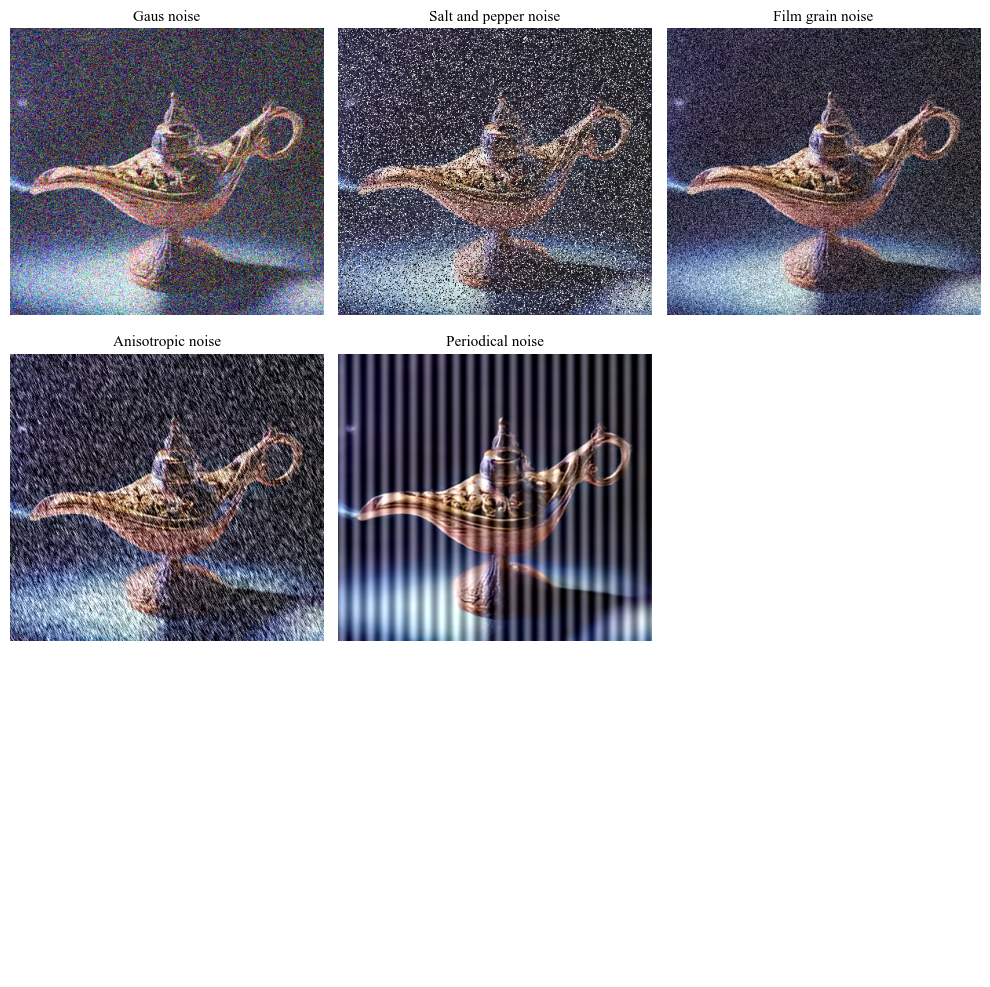

In [15]:
show(noise_images, noise_names, title="Noised images")

In [18]:
def evaluate_gaus():
    times = []
    for _ in range(100):
        st = time.time()
        gaus_filt = cv2.GaussianBlur(gaus, (0, 0), 1)
        f = time.time() - st
        times.append(f)
    return times

gaus_time = evaluate_gaus()
print(gaus_time)
print(np.mean(gaus_time))

[0.0030002593994140625, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010006427764892578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009992122650146484, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010001659393310547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00099945068359375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00099945068359375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010006427764892578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001001119613647461, 0.0, 0.0, 0.0, 0.0, 0.0]
0.00014000654220581055


In [19]:
def evaluate_mean():
    times = []
    for _ in range(100):
        st = time.time()
        gaus_filt = cv2.blur(film, (3, 3))
        f = time.time() - st
        times.append(f)
    return times

means_time = evaluate_mean()
print(means_time)
print(np.mean(means_time))

[0.0003516674041748047, 0.0, 0.0006477832794189453, 0.0, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0010013580322265625, 0.0, 0.0009992122650146484, 0.0, 0.0, 0.0009992122650146484, 0.0, 0.001001119613647461, 0.0, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.00099945068359375, 0.0, 0.00099945068359375, 0.0, 0.0, 0.0, 0.0010006427764892578, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0, 0.0010001659393310547, 0.0, 0.00099945068359375, 0.0, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.00099945068359375, 0.0, 0.0, 0.001001119613647461, 0.0, 0.0, 0.0009996891021728516, 0.0, 0.0, 0.00099945068359375, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0009999275207519531, 0.0, 0.0, 0.0, 0.00099945068359375, 0.0, 0.0010006427764892578, 0.0, 0.0, 0.00100183

In [20]:
def evaluate_med():
    times = []
    for _ in range(100):
        st = time.time()
        gaus_filt = cv2.medianBlur(sap, 3)
        f = time.time() - st
        times.append(f)
    return times

median_time = evaluate_med()
print(median_time)
print(np.mean(median_time))

[0.0, 0.0004050731658935547, 0.0, 0.0, 0.0, 0.0, 0.0005934238433837891, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010004043579101562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011126995086669922, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009908676147460938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010001659393310547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009975433349609375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010008811950683594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001001596450805664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009982585906982422, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001001119613647461, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009992122650146484, 0.0, 0.0, 0.0, 0.0, 0.0]
0.00011101245880126953


In [21]:
def evaluate_fft():
    times = []
    for _ in range(100):
        st = time.time()
        fft_filt = fft_denoise(per, k=1, l=9, frequency=17)
        f = time.time() - st
        times.append(f)
    return times

fft_time = evaluate_fft()
print(fft_time)
print(np.mean(fft_time))

[0.033217430114746094, 0.03200078010559082, 0.03199958801269531, 0.03700089454650879, 0.037999629974365234, 0.03200078010559082, 0.031998395919799805, 0.033000946044921875, 0.0390009880065918, 0.04426693916320801, 0.04700064659118652, 0.04700016975402832, 0.044999122619628906, 0.04635787010192871, 0.045638084411621094, 0.04060554504394531, 0.039519548416137695, 0.04822349548339844, 0.04699850082397461, 0.06423044204711914, 0.03958630561828613, 0.03669285774230957, 0.03754615783691406, 0.0331110954284668, 0.03194475173950195, 0.03168964385986328, 0.04177546501159668, 0.043999433517456055, 0.03605175018310547, 0.03304791450500488, 0.03366827964782715, 0.03250479698181152, 0.03316164016723633, 0.03354597091674805, 0.03317403793334961, 0.03499937057495117, 0.03520703315734863, 0.03401327133178711, 0.034455299377441406, 0.04101371765136719, 0.03499960899353027, 0.034448862075805664, 0.0451357364654541, 0.046598196029663086, 0.04522824287414551, 0.048368215560913086, 0.04273581504821777, 0.0

In [23]:
def evaluate_nlm():
    times = []
    for _ in range(100):
        st = time.time()
        nlm_filt = nlm_denoise(gaus, h = 31, templateWindowSize = 7, searchWindowSize = 21)
        f = time.time() - st
        times.append(f)
    return times

nlm_time = evaluate_nlm()
print(nlm_time)
print(np.mean(nlm_time))

[0.7534596920013428, 0.7431361675262451, 0.7485418319702148, 0.7229819297790527, 0.7564952373504639, 0.7170364856719971, 0.7575576305389404, 0.7425186634063721, 0.7300002574920654, 0.7732803821563721, 0.7271530628204346, 0.7908339500427246, 0.7307453155517578, 0.7639908790588379, 0.7541482448577881, 0.7282247543334961, 0.7507345676422119, 0.7469968795776367, 0.731151819229126, 0.7535126209259033, 0.7495958805084229, 0.7304928302764893, 0.7605574131011963, 0.7493979930877686, 0.7267379760742188, 0.749032735824585, 0.7379593849182129, 0.7367169857025146, 0.7484848499298096, 0.7403626441955566, 0.735586404800415, 0.7615702152252197, 0.7303464412689209, 0.7295072078704834, 0.7506732940673828, 0.7260012626647949, 0.7280755043029785, 0.7493584156036377, 0.7348546981811523, 0.7320079803466797, 0.7550008296966553, 0.7241542339324951, 0.7260005474090576, 0.7479989528656006, 0.725999116897583, 0.7289266586303711, 0.7449688911437988, 0.7239995002746582, 0.731001615524292, 0.7369985580444336, 0.73

In [22]:
def evaluate_anis():
    times = []
    for _ in range(100):
        st = time.time()
        nlm_filt = anis_denoise(anis, iterations = 11, delta_t = 0.5, kappa = 15, kSize = 3)
        f = time.time() - st
        times.append(f)
    return times

anis_time = evaluate_anis()
print(anis_time)
print(np.mean(anis_time))

[0.1359996795654297, 0.15399932861328125, 0.18500065803527832, 0.1959989070892334, 0.17600107192993164, 0.15599894523620605, 0.17388629913330078, 0.14252781867980957, 0.14624905586242676, 0.14346694946289062, 0.15536189079284668, 0.17304611206054688, 0.1685042381286621, 0.17185306549072266, 0.1641829013824463, 0.16718602180480957, 0.14584064483642578, 0.1258678436279297, 0.13681435585021973, 0.14438319206237793, 0.1514120101928711, 0.1715257167816162, 0.18794012069702148, 0.14092588424682617, 0.17031407356262207, 0.16438555717468262, 0.1547563076019287, 0.1432023048400879, 0.1426560878753662, 0.14313006401062012, 0.1408824920654297, 0.14563226699829102, 0.1815319061279297, 0.1918928623199463, 0.1772465705871582, 0.15991806983947754, 0.13180899620056152, 0.1348257064819336, 0.14645957946777344, 0.15711045265197754, 0.15768218040466309, 0.17856931686401367, 0.19875621795654297, 0.17786359786987305, 0.1658027172088623, 0.14379501342773438, 0.14861774444580078, 0.14421677589416504, 0.14889

In [16]:
def prepare_plot(filtered=[], filter_name="default"):
    temp = []
    temp += noise_images
    temp += filtered
    names = []
    names += noise_names

    letters = ["a.1)", "b.1)", "c.1)", "d.1)", "e.1)", "a.2)", "b.2)", "c.2)", "d.2)", "e.2)"]

    for i,f in enumerate(temp):
        rmse = np.sqrt(np.mean((image - f) ** 2))
        if i < 5:
            names[i] = f"{letters[i]} {names[i]}\nRMSE {rmse:.3f}"
        if i > 4:
            psnr = 20 * np.log10(255.0 / rmse)
            name = f"{letters[i]} {noise_names[i-5]} &\n{filter_name} filter\nRMSE {rmse:.3f} | PSNR {psnr:.3f}"
            names.append(name)

    print(len(temp))
    print(len(names))

    show(temp, names, rows=2, cols=5, title=f"{filter_name} denoise", size=(10,5))

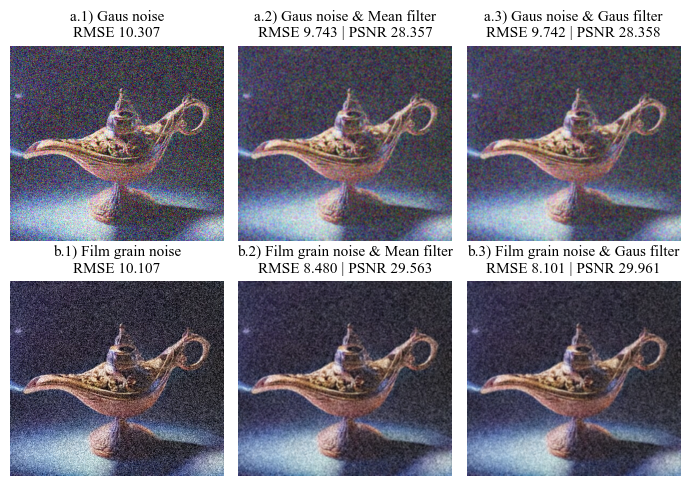

In [51]:
gaus_and_mean = [gaus, cv2.blur(gaus, (3, 3)), cv2.GaussianBlur(gaus, (0, 0), 1),
                film, cv2.blur(film, (3, 3)), cv2.GaussianBlur(film, (0, 0), 1)]

rmses = [np.sqrt(np.mean((gaus_and_mean[0] - image) ** 2)), np.sqrt(np.mean((gaus_and_mean[1] - image) ** 2)), np.sqrt(np.mean((gaus_and_mean[2] - image) ** 2)),
         np.sqrt(np.mean((gaus_and_mean[3] - image) ** 2)), np.sqrt(np.mean((gaus_and_mean[4] - image) ** 2)), np.sqrt(np.mean((gaus_and_mean[5] - image) ** 2))]

psnrs = [20 * np.log10(255.0 / rmses[1]), 20 * np.log10(255.0 / rmses[2]),
         20 * np.log10(255.0 / rmses[4]), 20 * np.log10(255.0 / rmses[5])]

names = [f"a.1) Gaus noise\nRMSE {rmses[0]:.3f}",
             f"a.2) Gaus noise & Mean filter\nRMSE {rmses[1]:.3f} | PSNR {psnrs[0]:.3f}",
             f"a.3) Gaus noise & Gaus filter\nRMSE {rmses[2]:.3f} | PSNR {psnrs[1]:.3f}",
             f"b.1) Film grain noise\nRMSE {rmses[3]:.3f}",
             f"b.2) Film grain noise & Mean filter\nRMSE {rmses[4]:.3f} | PSNR {psnrs[2]:.3f}",
             f"b.3) Film grain noise & Gaus filter\nRMSE {rmses[5]:.3f} | PSNR {psnrs[3]:.3f}"]

show(gaus_and_mean, names, title="gaus-and-film-grain-noise", rows=2, cols=3, size=(7,5))

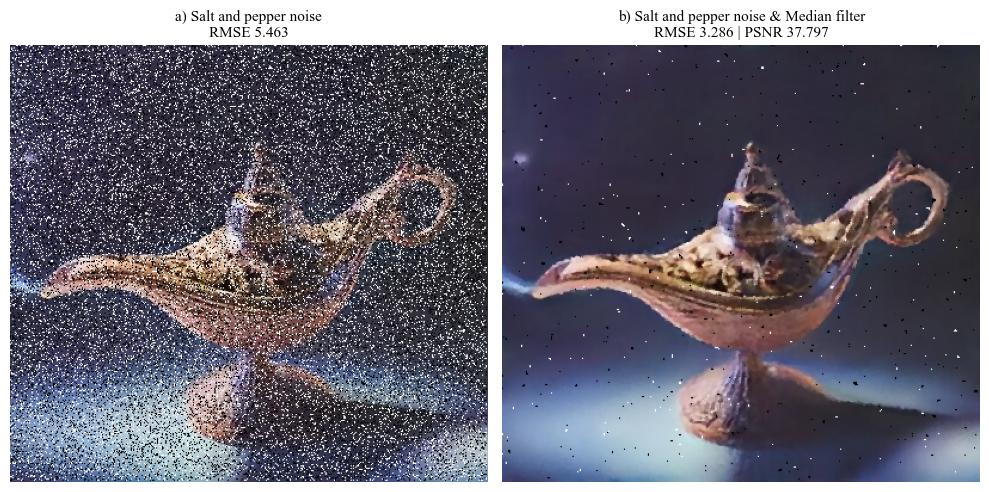

In [54]:
meadian = [sap, cv2.medianBlur(sap, 3)]

rmses = [np.sqrt(np.mean((meadian[0] - image) ** 2)), np.sqrt(np.mean((meadian[1] - image) ** 2))]

psnrs = [20 * np.log10(255.0 / rmses[1])]

names = [f"a) Salt and pepper noise\nRMSE {rmses[0]:.3f}", f"b) Salt and pepper noise & Median filter\nRMSE {rmses[1]:.3f} | PSNR {psnrs[0]:.3f}"]

show(meadian, names, title="salt-and-pepper-noise", rows=1, cols=2, size=(10,6))

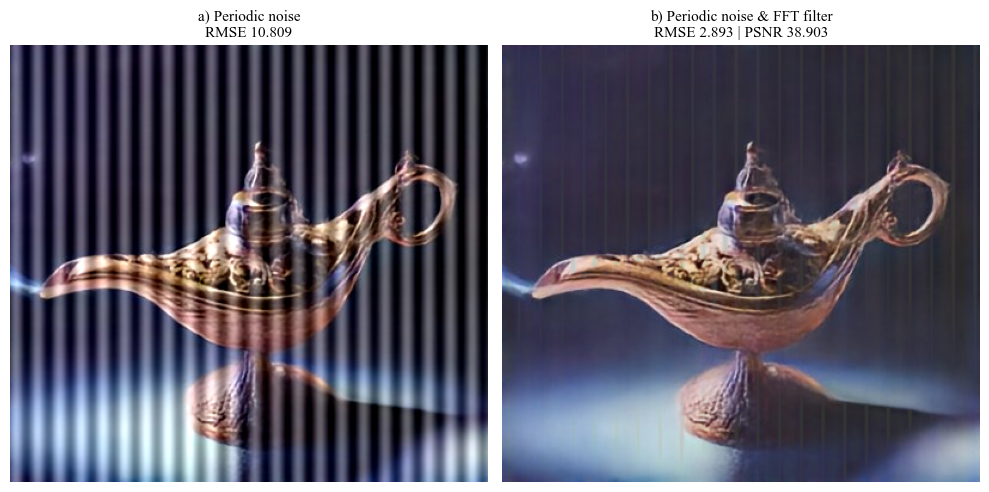

In [17]:
fft_denoised = [per, fft_denoise(per, k=1, l=9, frequency=17)]

rmses = [np.sqrt(np.mean((fft_denoised[0] - image) ** 2)), np.sqrt(np.mean((fft_denoised[1] - image) ** 2))]

psnrs = [20 * np.log10(255.0 / rmses[1])]

names = [f"a) Periodic noise\nRMSE {rmses[0]:.3f}", f"b) Periodic noise & FFT filter\nRMSE {rmses[1]:.3f} | PSNR {psnrs[0]:.3f}" ]

show(fft_denoised, names, rows=1, cols=2, title="FFT denoise", size=(10,6))

10
10


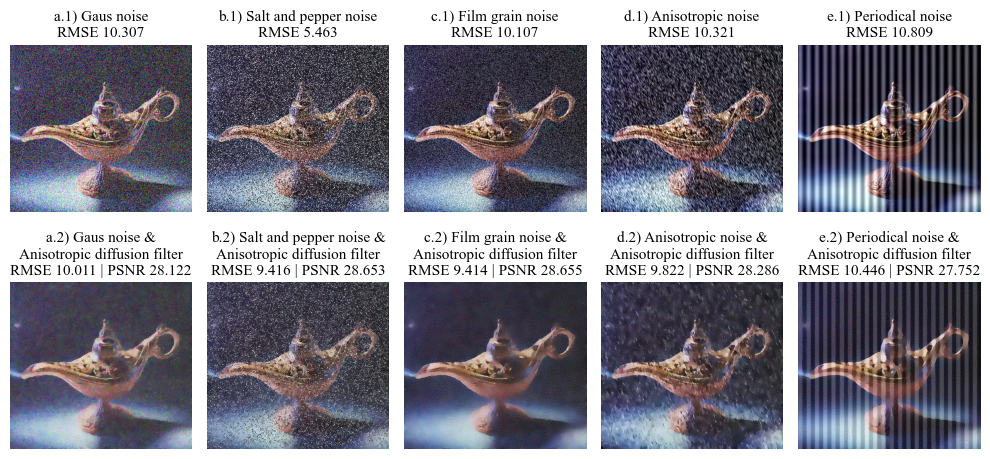

In [60]:
anis_filtered = [anis_denoise(x, iterations = 11, delta_t = 0.5, kappa = 15, kSize = 3) for x in noise_images]
prepare_plot(anis_filtered, "Anisotropic diffusion")

10
10


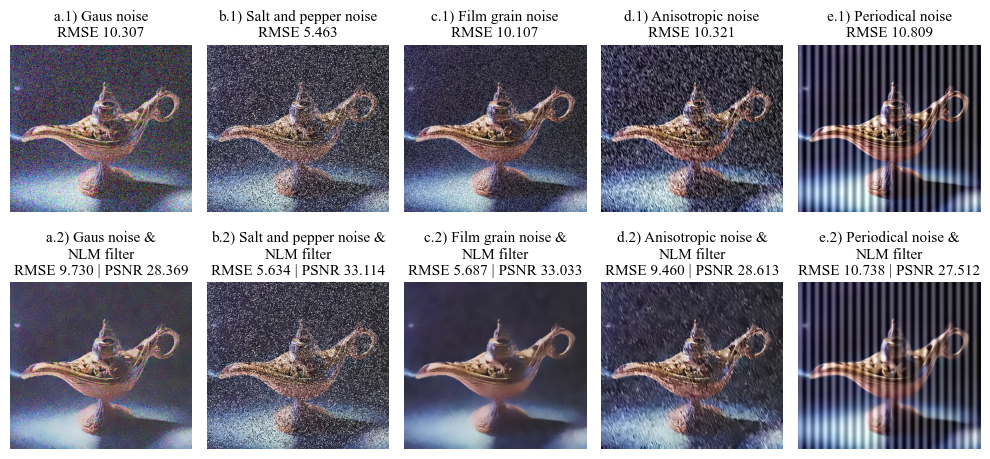

In [73]:
nlm_filtered = [nlm_denoise(x, h = 31, templateWindowSize = 7, searchWindowSize = 21) for x in noise_images]
prepare_plot(nlm_filtered, "NLM")

In [26]:
def plot_perf():
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(means_time)), means_time, marker='o', color='r', label = "'Mean Blur' execution time", markeredgewidth=0.5, markersize=2)
    plt.plot(range(len(gaus_time)), gaus_time, marker='o', color='b', label = "'Gaussian Blur' execution time", markeredgewidth=0.5, markersize=2)
    plt.plot(range(len(median_time)), median_time, marker='o', color='g', label = "'Median Blur' execution time", markeredgewidth=0.5, markersize=2)
    plt.plot(range(len(fft_time)), fft_time, marker='o', color='y', label = "'FFT Transform' execution time", markeredgewidth=0.5, markersize=2)
    plt.plot(range(len(nlm_time)), nlm_time, marker='o', color='c', label = "'NLM Filter' execution time", markeredgewidth=0.5, markersize=2)
    plt.plot(range(len(anis_time)), anis_time, marker='o', color='m', label = "'Anisotropic Diffusion' execution time", markeredgewidth=0.5, markersize=2)

    plt.title('Filters execution time comparison')
    plt.xlabel('Iteration')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filePath}-performance-plot.jpg', format='jpg', dpi=600)
    plt.show()


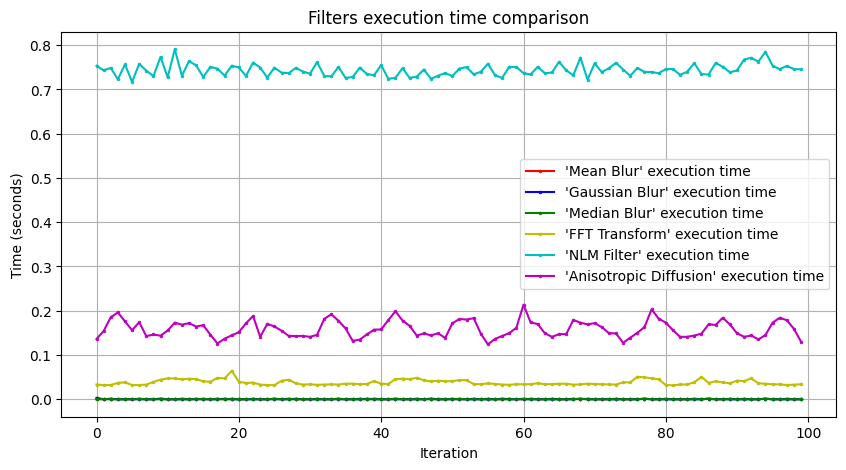

In [25]:
plot_perf()